<a href="https://colab.research.google.com/github/charlesyoo/2023-Predictive-Analytics/blob/main/Final_Charles_Yoo_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
import itertools
import pandas as pd
import numpy as np
import string
import nltk
import nltk.corpus
import sklearn
import csv
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk import NaiveBayesClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from keras.models import load_model

# tokenize the dataset corpus, delete uncommon words such as names.
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text, sequence
from IPython.display import display, HTML
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, accuracy_score, f1_score,recall_score, roc_auc_score,precision_recall_curve, average_precision_score, auc, roc_curve
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.metrics import classification_report

from keras.utils import plot_model
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pickle

sns.set()

In [174]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [188]:
data = pd.read_csv('https://raw.githubusercontent.com/charlesyoo/ML-Data/main/Apple-Twitter-Sentiment-DFE%20-%20Apple-Twitter-Sentiment-DFE.csv')

# EDA

In [189]:
data.head(10)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL
5,623495518,True,golden,13,NaN,3,0.5975,Mon Dec 01 20:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,5,#AAPL:5 Rocket Stocks to Buy for December Gain...
6,623495519,True,golden,13,NaN,5,0.8468,Mon Dec 01 20:32:45 +0000 2014,5.400000e+17,#AAPL OR @Apple,5,Top 3 all @Apple #tablets. Damn right! http://...
7,623495520,True,golden,9,NaN,5,0.6736,Mon Dec 01 20:34:31 +0000 2014,5.400000e+17,#AAPL OR @Apple,5\n3,CNBCTV: #Apple's margins better than expected?...
8,623495521,True,golden,15,NaN,3,0.7997,Mon Dec 01 20:36:47 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,Apple Inc. Flash Crash: What You Need to Know ...
9,623495522,False,finalized,3,12/12/14 0:52,3,0.6360,Mon Dec 01 20:45:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,#AAPL:This Presentation Shows What Makes The W...


In [190]:
data.describe()

,_unit_id,_trusted_judgments,sentiment:confidence,id
count,3.886000e+03,3886.000000,3886.000000,3.886000e+03
mean,6.234975e+08,3.687082,0.829526,5.410039e+17
std,1.171906e+03,2.004595,0.175864,7.942752e+14
min,6.234955e+08,3.000000,0.332700,5.400000e+17
25%,6.234965e+08,3.000000,0.674475,5.400000e+17
50%,6.234975e+08,3.000000,0.811250,5.410000e+17
75%,6.234984e+08,3.000000,1.000000,5.420000e+17
max,6.235173e+08,27.000000,1.000000,5.420000e+17


In [191]:
data['_trusted_judgments'].value_counts()

3     3063
6      362
4      309
5       29
13      17
12      15
14      14
7       11
8       10
16       9
17       9
15       9
10       6
11       6
9        6
19       5
18       3
22       2
27       1
Name: _trusted_judgments, dtype: int64

In [192]:
# How many reviews we have
print('There are', data.shape[0], 'tweeets')

# check for duplicates
print("There are", len(data[data.duplicated()]), "duplicates")

# check if we have missing values
print("There are", data.isnull().sum().sum(), "missing values")

There are 3886 tweeets
There are 0 duplicates
There are 3886 missing values


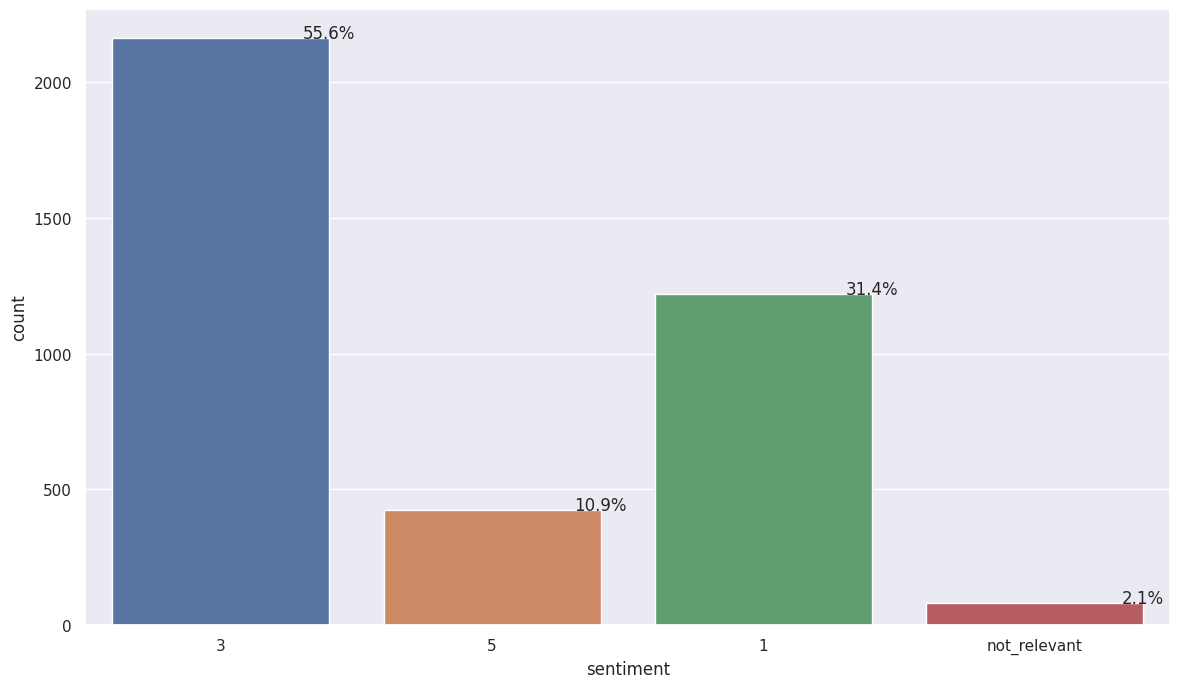

In [193]:
plt.figure(figsize=(14,8))
total = float(len(data))
ax = sns.countplot(x="sentiment", data=data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [194]:
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [195]:
data[data['sentiment:confidence'] == 1][data["_golden"]== True].head(10)

<ipython-input-195-e89392efb093>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['sentiment:confidence'] == 1][data["_golden"]== True].head(10)


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
2,623495515,True,golden,10,NaN,3,1.0,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
10,623495523,True,golden,12,NaN,1,1.0,Mon Dec 01 20:46:01 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
14,623495527,True,golden,17,NaN,1,1.0,Mon Dec 01 21:09:50 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,@apple Contact sync between Yosemite and iOS8 ...
23,623495536,True,golden,13,NaN,1,1.0,Mon Dec 01 23:55:55 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,"@Apple, For the love of GAWD, CENTER the '1'on..."
37,623495550,True,golden,9,NaN,3,1.0,Tue Dec 02 00:23:47 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,http://t.co/hpC7p1rHvA\nneed help on using you...
44,623495557,True,golden,10,NaN,1,1.0,Tue Dec 02 00:29:58 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,"Ok, @apple. You win. I won't use your browser ..."
47,623495560,True,golden,16,NaN,1,1.0,Tue Dec 02 00:34:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,@apple U need to get ur fucking shit together ...
57,623495570,True,golden,14,NaN,1,1.0,Tue Dec 02 00:53:58 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,hey @apple fuck you
63,623495576,True,golden,18,NaN,1,1.0,Tue Dec 02 01:05:37 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,"As a die hard @Apple customer, I must say I am..."
163,623495676,True,golden,17,NaN,1,1.0,Tue Dec 02 06:52:06 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,fucking faggots @apple


In [196]:
data['sentiment'] = data['sentiment'].replace('not_relevant', '0')

In [197]:
data['sentiment'] = pd.to_numeric(data['sentiment'])

In [198]:
data.drop(data[data['sentiment'] == 0].index, inplace=True)


In [199]:
data['sentiment'].value_counts()

3    2162
1    1219
5     423
Name: sentiment, dtype: int64

In [201]:
#  data's categories
categories = pd.DataFrame(data['sentiment'].apply(lambda x: 1 if (x > 3) else 0) ).to_numpy()
categories

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [118]:
# create new  column called sentiment and store the pos for rate over 3 and negaive for the rest
data['sentiment_level'] = data['sentiment'].apply(lambda x: "Positive" if (x > 3) else "Negative")
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text,sentiment_level
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...,Neutral
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,Neutral
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...,Neutral
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...,Neutral
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL,Neutral


In [203]:
data.head(30)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text,sentiment_level
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...,Negative
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,Negative
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...,Negative
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...,Negative
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL,Negative
5,623495518,True,golden,13,NaN,3,0.5975,Mon Dec 01 20:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,5,#AAPL:5 Rocket Stocks to Buy for December Gain...,Negative
6,623495519,True,golden,13,NaN,5,0.8468,Mon Dec 01 20:32:45 +0000 2014,5.400000e+17,#AAPL OR @Apple,5,Top 3 all @Apple #tablets. Damn right! http://...,Positive
7,623495520,True,golden,9,NaN,5,0.6736,Mon Dec 01 20:34:31 +0000 2014,5.400000e+17,#AAPL OR @Apple,5\n3,CNBCTV: #Apple's margins better than expected?...,Positive
8,623495521,True,golden,15,NaN,3,0.7997,Mon Dec 01 20:36:47 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,Apple Inc. Flash Crash: What You Need to Know ...,Negative
9,623495522,False,finalized,3,12/12/14 0:52,3,0.6360,Mon Dec 01 20:45:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,#AAPL:This Presentation Shows What Makes The W...,Negative


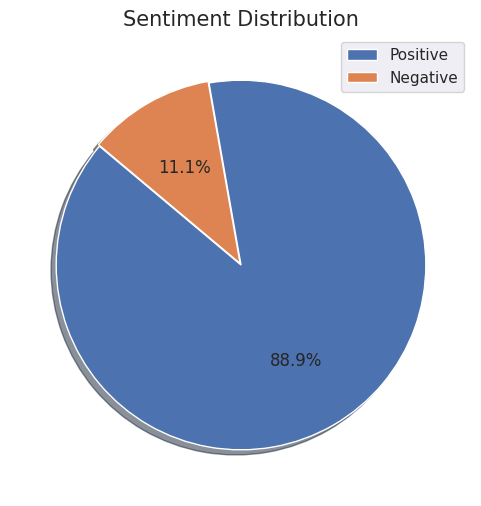

In [209]:
plt.figure(figsize=(6, 6))

explode = [0, 0.01]
plt.pie(data['sentiment_level'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['Positive', 'Negative'])
plt.title('Sentiment Distribution', fontsize=15)
plt.axis('off');

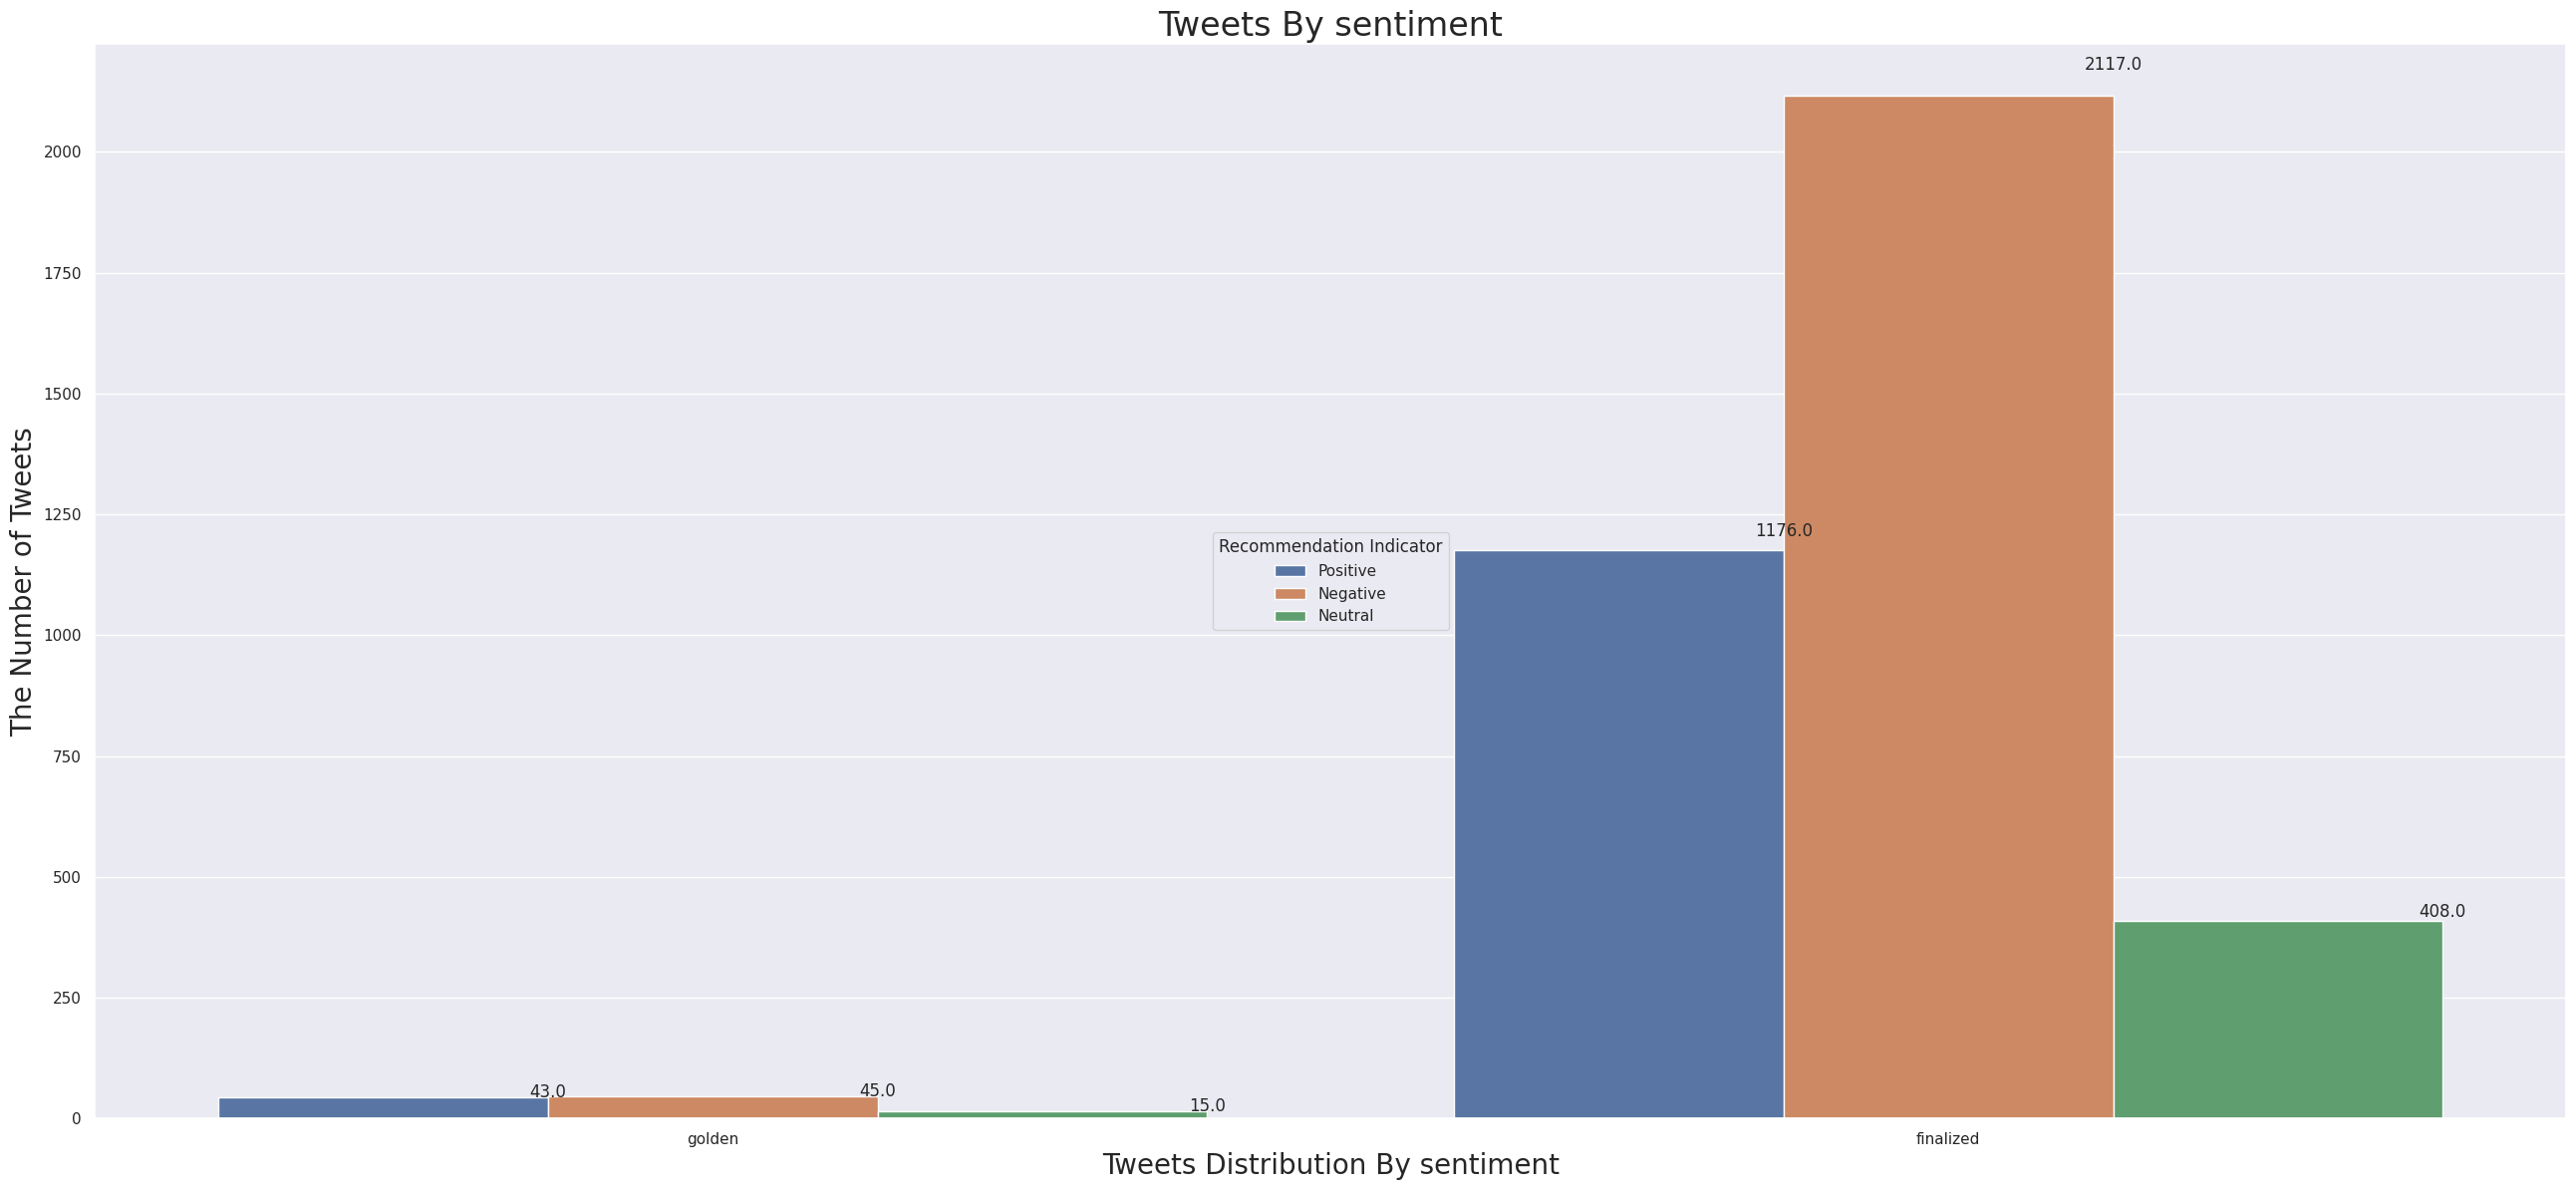

In [210]:
# It seems that the majority of customers have given positive feedback about the device

plt.figure(figsize=(32,14))
total = float(len(data))
ax = sns.countplot(x="_unit_state", hue = "sentiment", data=data)

plt.title('Tweets By sentiment', fontsize=24)
plt.xlabel("Tweets Distribution By sentiment", fontsize=20)
plt.ylabel("The Number of Tweets", fontsize=20)
plt.legend(title='Recommendation Indicator', loc='center', labels=['Positive', 'Negative', 'Neutral'])

for p in ax.patches:
   # percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()* 1.025
    ax.annotate(p.get_height(), (x, y),ha='center')

plt.show()

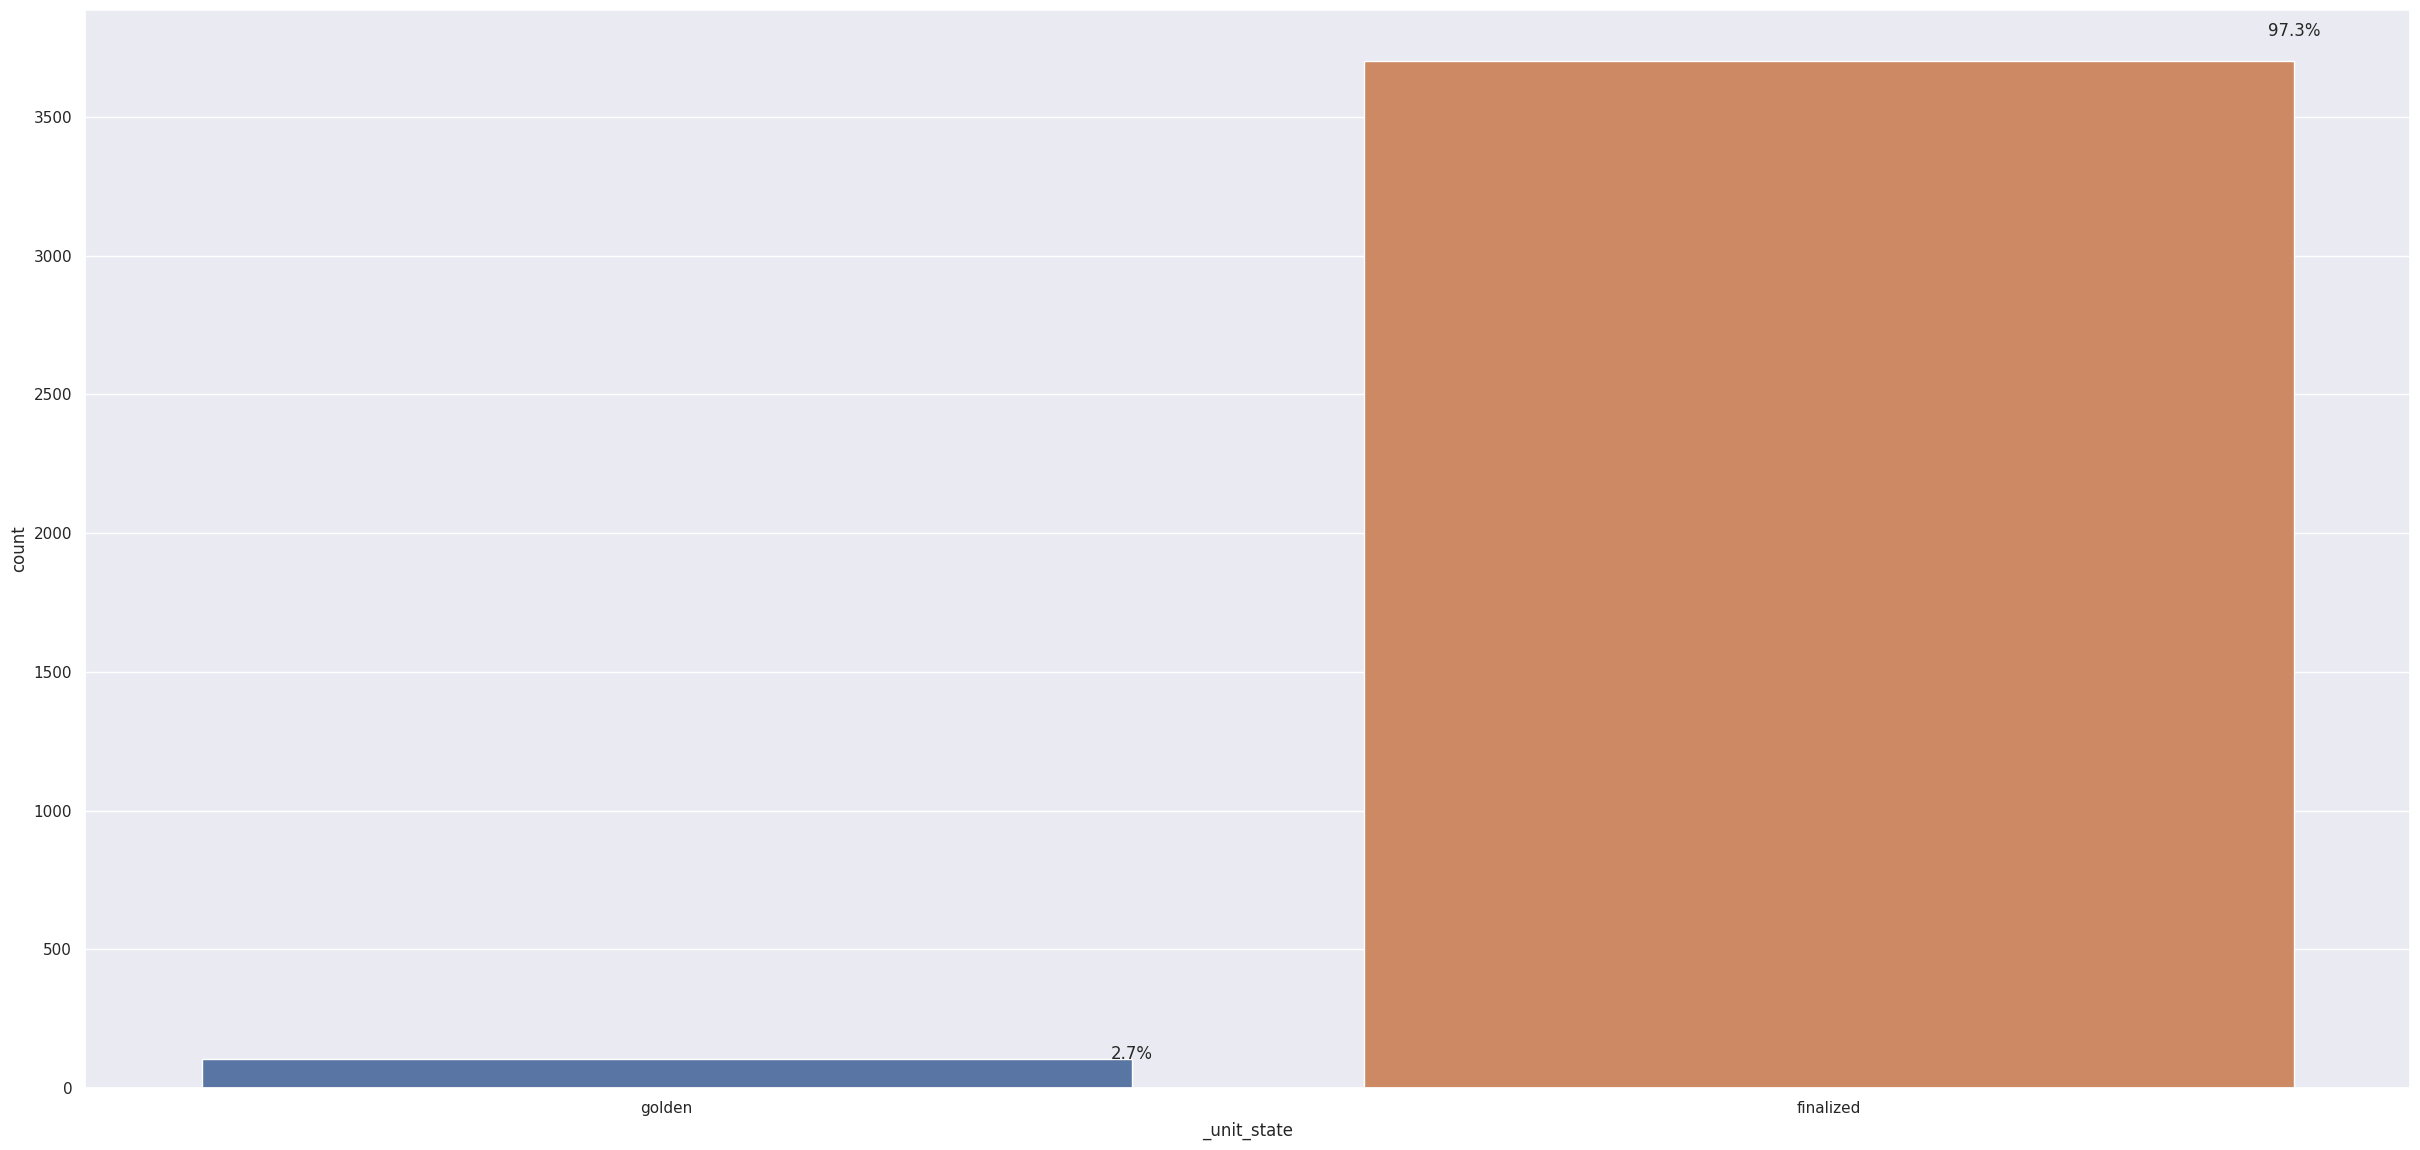

In [211]:
plt.figure(figsize=(30,14))
total = float(len(data))
ax = sns.countplot(x="_unit_state", data=data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()* 1.025
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

### Feature Extraction

In [212]:
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text,sentiment_level
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...,Negative
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,Negative
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...,Negative
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...,Negative
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL,Negative


In [213]:

# Check if the DataFrame has an index
has_index = data.index.any()

# Display the result
print("Does the DataFrame have an index?", has_index)

Does the DataFrame have an index? True


In [214]:
# For NLP we will keep only the necessary columns such as "text" and "sentiment-level" columns and we will drop the rest
data.drop(["_unit_id", "_golden", "_unit_state", "_trusted_judgments", "_last_judgment_at", "sentiment", "sentiment:confidence", "date", "id", "query", "sentiment_gold"], axis = 1, inplace = True)

In [215]:
data.head()

,text,sentiment_level
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,Negative
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,Negative
2,My cat only chews @apple cords. Such an #Apple...,Negative
3,I agree with @jimcramer that the #IndividualIn...,Negative
4,Nobody expects the Spanish Inquisition #AAPL,Negative


In [218]:
# Check if the DataFrame has an index
has_index = data.index.any()

# Display the result
print("Does the DataFrame have an index?", has_index)

Does the DataFrame have an index? True


In [219]:
# create lemmatizer
lemmatizer = WordNetLemmatizer()

In [228]:
# function to get the simpler virsion of pos tag  to use  in lemmitazation
def get_simple_pos(tag):
    if tag.startswith('N') or tag.startswith('J'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [229]:
data.index = data.index.map(lambda x: x + 1)

In [234]:
def clean_texts(tweet):
    # Remove retweets (e.g., RT @username:)
    raw_tweet = re.sub(r'\bRT\b\s*@\w+:\s*', '', tweet)

    # Remove mentions (e.g., @username)
    raw_tweet = re.sub(r'@\w+', '', raw_tweet)

    # Remove hashtags and the following word
    raw_tweet = re.sub(r'#\w+\s*', '', raw_tweet)

    # Remove links (e.g., http://example.com)
    raw_tweet = re.sub(r'http\S+', '', raw_tweet)

    # Remove non-alphabetic characters (except spaces)
    raw_tweet = re.sub("[^a-zA-Z ]", " ", raw_tweet)

    # Remove numbers
    raw_tweet = re.sub("\d+(\.\d+)?", " ", raw_tweet)

    stop_words = set(stopwords.words("english"))
    words_tokens = word_tokenize(raw_tweet)
    clean_words = []

    for word, tag in pos_tag(words_tokens):
        if word.lower() not in stop_words:
            pos = get_simple_pos(tag)  # Use the get_simple_pos function here
            clean_word = lemmatizer.lemmatize(word.lower(), pos=pos)
            clean_words.append(clean_word)

    return " ".join(clean_words)

In [235]:
# store the cleaned text inside clean_text_corpus array
clean_text_corpus = []

for index, tweet in enumerate(data["text"]):
    # Check if the string is empty before calling clean_texts
    if tweet:
        clean_text_corpus.append(clean_texts(tweet))
    else:
        # If the tweet is empty, append an empty string
        clean_text_corpus.append("")

# Now clean_text_corpus contains your cleaned texts

In [236]:
data["text"] = data["text"].apply(clean_tweets)
data["text"].head()

1       aapl best steve job email ever http co g kl tx
2    rt jpdesloges aapl stock mini flash crash toda...
3                        cat chew apple cord applesnob
4    agree jimcramer individualinvestor trade apple...
5               nobody expect spanish inquisition aapl
Name: text, dtype: object

In [237]:
data.head()

,text,sentiment_level
1,aapl best steve job email ever http co g kl tx,Negative
2,rt jpdesloges aapl stock mini flash crash toda...,Negative
3,cat chew apple cord applesnob,Negative
4,agree jimcramer individualinvestor trade apple...,Negative
5,nobody expect spanish inquisition aapl,Negative


In [238]:
print("review 5 cleaned {",data["text"][5],"}")

review 5 cleaned { nobody expect spanish inquisition aapl }


In [239]:
words_values = pd.Series(" ".join(data["text"]).split()).value_counts()
print(words_values)
rare_words = words_values[words_values <= 3]
print(rare_words)
print(rare_words.value_counts())

apple         3940
co            2275
http          2264
aapl          1321
rt             843
              ... 
hfvauozsox       1
pei              1
ofam             1
fcocuengin       1
unhelpful        1
Length: 7736, dtype: int64
audience      3
underway      3
sv            3
qhpim         3
jimmy         3
             ..
hfvauozsox    1
pei           1
ofam          1
fcocuengin    1
unhelpful     1
Length: 6309, dtype: int64
1    4827
2    1043
3     439
dtype: int64


In [240]:
data["text"] = data["text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
data["text"].head()

1             aapl best steve job email ever http co g
2    rt jpdesloges aapl stock mini flash crash toda...
3                                       cat apple cord
4      agree jimcramer trade apple aapl today good see
5                                          expect aapl
Name: text, dtype: object

In [241]:
# Create function to display wordcload
def create_WordCloud(data, back_ground_color = "black", title = None):
  wordcloud = WordCloud(background_color=back_ground_color, max_words=300, max_font_size=30 , scale=3,random_state=1).generate(str(data))
  mpl.rcParams['figure.figsize']=(15,15)
  mpl.rcParams['font.size']=20
  #plt.style.use('fast')
  fig = plt.figure(1)
  if title:
    plt.title(title, fontsize= 30)

  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

In [249]:
# seprate the pos and neg words
#Negative_words = " ".join(data[data["text"]  =="0"]in categories).split()

# seprate the pos and neg words
Negative_words =[]
Positive_words=[]


#clean_reviews(data["verified_reviews"][index]
for index, num in enumerate(categories):
    if num == 1:
        Positive_words.append(data["text"].iloc[index])
    else:
        Negative_words.append(data["text"].iloc[index])

In [31]:
Negative_words[:20]

['without use many feature ipad see use great alarm u almost hear alarm bedroom living room reason enough keep fun ask random question hear response seem yet',
 'get second unit bedroom expect sound improve didnt really see difference overall big improvement st generation',
 'speaker sound pretty good small setup pretty easy bought two reason rate follow instruction music unit know do correctly sync purchasing multiple unit',
 'like siri fact siri answer alexa see real need household though good prime day deal',
 'different apple play specific list music must amazon spotify plus prime etc account must pay play music star reason everything else',
 'like google well',
 'sound terrible u want good music get bose',
 'much feature',
 'annoy everything show alexa able download spend much time try figure machine may well look',
 'know half thing ask recognize wifi even though product detail say compatible program change wifi thermostat setting match wifi router handy music player amazon music

In [245]:
Positive_words[:20]

['top apple tablet damn right http co',
 'cnbctv apple margin well expect aapl http co',
 'rt bought apple store pretty good logo match wait install http co z',
 'latest apple product lead http co fj apple iphone ipad',
 'rt apple thanks think upgrade',
 'photo love io apple iphone love io iphone young phone screen http co',
 'update gb apple guy like take money dammit look good',
 'apple io user account online sale x android user business sale cybermonday',
 'apple please new phone christmas',
 'well apple http co',
 'thank apple',
 'rt thank apple',
 'apple love product power cord junk seriously need fix',
 'aapl rt apple share benefit billion http co',
 'even apple watch raise aapl price target http co aapl alex',
 'love airmiles amp apple earn sale cybermonday',
 'surface maybe good product never well apple macbook air fact',
 'netflix apple tim cook great news hope wifi get sort though',
 'apple photo http co',
 'service today apple store thanks amp sort battery problem amp']

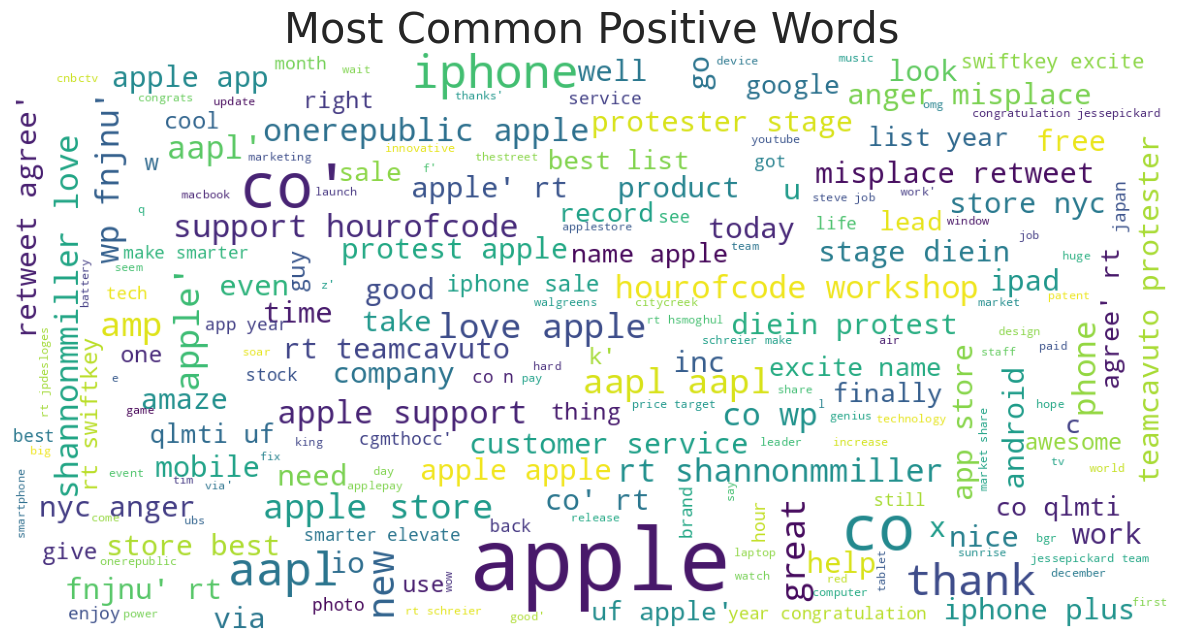

In [246]:
# wordcload for positive words
create_WordCloud(Positive_words, back_ground_color = "white", title = "Most Common Positive Words")

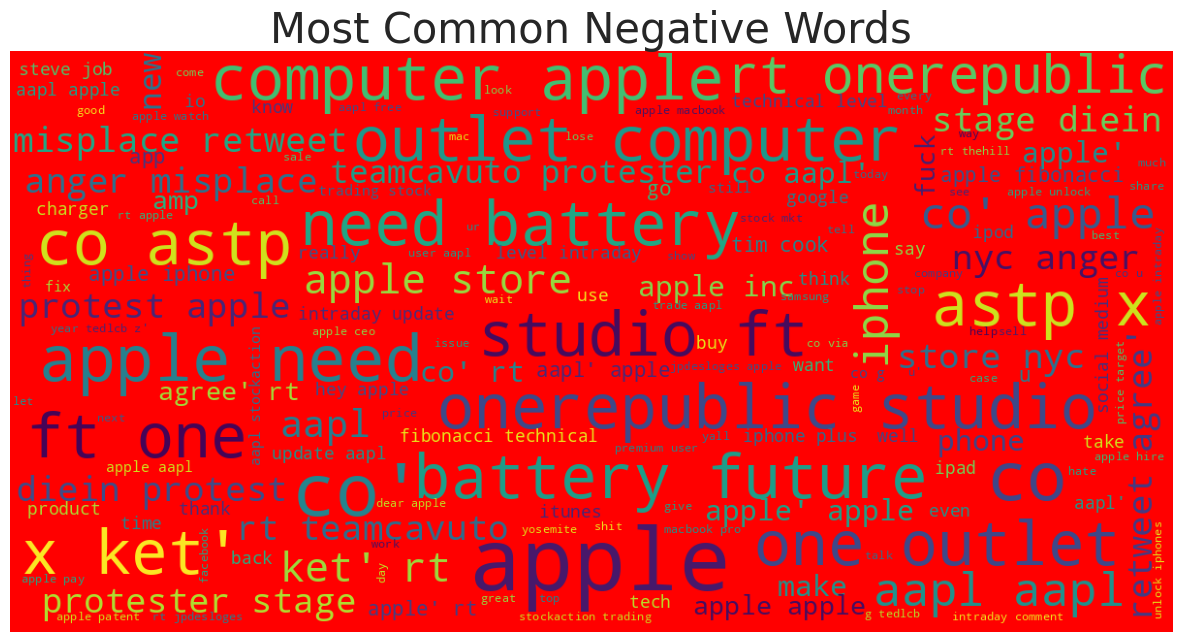

In [247]:
# wordcload for negative words
create_WordCloud(Negative_words, back_ground_color="red",title="Most Common Negative Words")

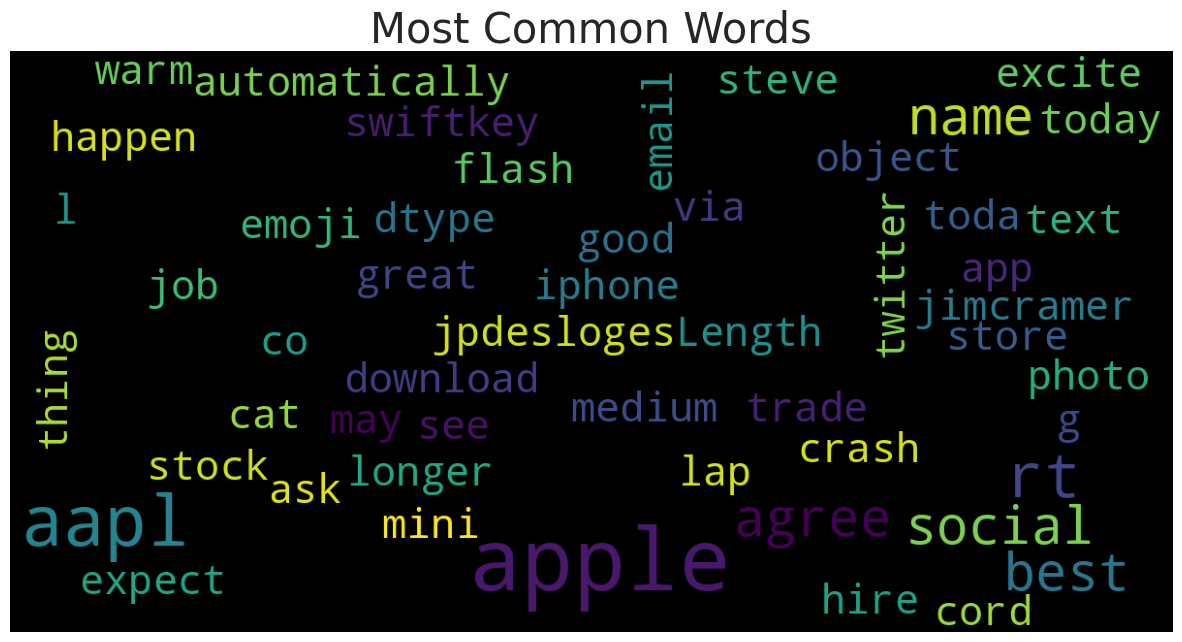

In [248]:
# wordcload for all words
create_WordCloud(data["text"], title = "Most Common Words")

In [250]:
# Top 15 words are in positive reviews
freq_pos = nltk.FreqDist(Positive_words)
freq_pos.most_common(15)

[('rt shannonmmiller love apple support hourofcode workshop http co wp fnjnu',
  19),
 ('rt teamcavuto protester stage diein protest apple store nyc anger misplace retweet agree',
  12),
 ('rt swiftkey excite name apple app store best list year http co qlmti uf apple',
  7),
 ('rt schreier make smarter elevate apple app year congratulation jessepickard team http co r cgmthocc',
  5),
 ('onerepublic apple', 4),
 ('rt hsmoghul apple autocorrect change muslim awesome okay', 4),
 ('apple earns profit quarter amazon earn lifetime amazon apple http co', 3),
 ('thank apple', 2),
 ('apple new io excellent update phone http co', 2),
 ('goodbye graphic problem thank apple great customer service http co', 2),
 ('rt thestreet apple survive holiday investor say yes http co n k', 2),
 ('apple inc brand value jump company soar even http co aapl', 2),
 ('biggest difference mac pc yep stick mac apple http co apple', 2),
 ('top apple tablet damn right http co', 1),
 ('cnbctv apple margin well expect aap

In [251]:
# Top 15 words are in negative reviews
freq_neg=nltk.FreqDist(Negative_words)
freq_neg.most_common(10)

[('rt onerepublic studio ft one outlet computer apple need battery future http co astp x ket',
  303),
 ('rt teamcavuto protester stage diein protest apple store nyc anger misplace retweet agree',
  138),
 ('apple fibonacci technical level intraday update aapl aapl http co', 22),
 ('rt thehill justice department cite th century federal law get apple unlock iphones http co eth qpaiom',
  18),
 ('apple intraday comment update range premium user aapl stockaction trading stock mkt http co g tedlcb z',
  15),
 ('block trade detect aapl', 14),
 ('trade aapl free nightly update post twitter visit trade aapl free website http co u tkeapbxf',
  12),
 ('apple ceo tim cook come gay apple http co eufqqpmjj via posh net', 12),
 ('apple', 12),
 ('rt cruci btch harry potter emojis please work apple', 11)]

# Deep Learning

## Test, Train Split & Vectorization

In [252]:
# train-test-split
x_train, x_test, y_train, y_test = train_test_split(data["text"], categories, stratify = categories, test_size = 0.20, random_state = 42)

In [253]:
# Vectorization
# here we create new CountVectorizer, which will help us understand and count the words.
# and it has different ways to use it, but we will only use it with  2-3 gram
count_vec = CountVectorizer(ngram_range = (1,2))

In [255]:
# vectorizer to read the train text for us
x_train_features = count_vec.fit_transform(x_train)
x_train_features = x_train_features.toarray() # to get the frequincy of the words

In [257]:
x_test_features = count_vec.transform(x_test)

In [42]:
# https://towardsdatascience.com/text-vectorization-term-frequency-inverse-document-frequency-tfidf-5a3f9604da6d#:~:text=Term%20Frequency%20%E2%80%94%20Inverse%20Document%20Frequency%20(TFIDF)%20is%20a%20technique,in%20a%20document%20into%20consideration.


In [258]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_Tfid = tfidf_vectorizer.fit_transform(x_train)
X_test_Tfid = tfidf_vectorizer.transform(x_test)

In [259]:
X_train_Tfid.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.11524585, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Deep Learning -- Neural Network

In [260]:
# find the length of the largest sentence in training data
max_len = max(x_train, key = len)
print(f'Max number of words in a text in training data: {len(max_len)}')

Max number of words in a text in training data: 118


In [262]:
# Convert reviews to padded sequences
max_words = 118
tokenizer = Tokenizer(num_words = max_words)

In [263]:
# create the vocabulary by fitting on X_train text
tokenizer.fit_on_texts(x_train)

In [264]:
# get the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(x_train)
xtest_seq = tokenizer.texts_to_sequences(x_test)

In [265]:
# padding the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=len(max_len))
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=len(max_len))
word_index = tokenizer.word_index

In [266]:
# get a random example
print('train review num 10:', x_train[9])
print('before padding:', xtrain_seq[9])
print('after padding:', xtrain_pad[9])

train review num 10: apple inc flash crash need know http co aapl
before padding: [5, 10, 15, 14, 8, 16, 9, 1, 7, 11, 13, 3, 2, 17, 12, 18]
after padding: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  5 10 15 14  8 16  9  1  7 11 13  3  2 17 12 18]


In [267]:
# data shape after padding
print(xtrain_pad.shape)
print(xtest_pad.shape)
print(y_train.shape)
print(y_test.shape)

(3043, 118)
(761, 118)
(3043, 1)
(761, 1)


### Creating the network

In [271]:
def create_model():
    model = tf.keras.models.Sequential([tf.keras.layers.Embedding(max_words, 100, input_length=max_words),
                                        tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, padding ='same', activation='relu'),
                                        tf.keras.layers.MaxPooling1D(pool_size = 2),
                                        tf.keras.layers.LSTM(256),
                                        tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(3e-4), metrics=['accuracy'])
    return model

In [272]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 118, 100)          11800     
                                                                 
 conv1d_2 (Conv1D)           (None, 118, 32)           6432      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 59, 32)            0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 256)               295936    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 314425 (1.20 MB)
Trainable params: 314425 (1.20 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

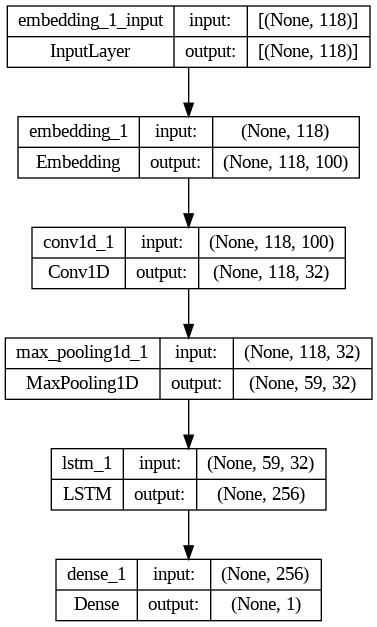

In [270]:
# print the block diagram of our model
plot_model(model, show_shapes = True, show_layer_names = True)

### Training the Network

In [273]:
# create model checkpoint and callbacks to save the model weights when validation accuracy is maximum
callback=tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 2, mode = 'auto', baseline = None, restore_best_weights = True)

In [274]:
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

Found GPU at: /device:GPU:0


In [275]:
# fit the model
with tf.device('/device:GPU:0'):
    history = model.fit(xtrain_pad, y_train, validation_data = (xtest_pad, y_test), class_weight = {0:87, 1:13}, epochs = 10, batch_size = 32)

Epoch 1/10
96/96 [==============================] - 10s 74ms/step - loss: 13.7761 - accuracy: 0.8791 - val_loss: 0.4578 - val_accuracy: 0.8883
Epoch 2/10
96/96 [==============================] - 2s 24ms/step - loss: 7.2150 - accuracy: 0.8889 - val_loss: 0.4506 - val_accuracy: 0.8883
Epoch 3/10
96/96 [==============================] - 1s 11ms/step - loss: 7.2151 - accuracy: 0.8889 - val_loss: 0.4402 - val_accuracy: 0.8883
Epoch 4/10
96/96 [==============================] - 1s 15ms/step - loss: 7.1399 - accuracy: 0.8889 - val_loss: 0.4454 - val_accuracy: 0.8883
Epoch 5/10
96/96 [==============================] - 1s 14ms/step - loss: 6.9818 - accuracy: 0.8889 - val_loss: 0.4321 - val_accuracy: 0.8883
Epoch 6/10
96/96 [==============================] - 1s 11ms/step - loss: 6.8372 - accuracy: 0.8889 - val_loss: 0.4374 - val_accuracy: 0.8883
Epoch 7/10
96/96 [==============================] - 1s 12ms/step - loss: 6.7241 - accuracy: 0.8889 - val_loss: 0.4301 - val_accuracy: 0.8883
Epoch 8/10


In [276]:
# predict probabilities for test set
y_probs = model.predict(xtest_pad, verbose = 0)

In [277]:
# predict classes for test set
y_classes = (model.predict(xtest_pad) > 0.5).astype("int32")
y_train_pred=(model.predict(xtrain_pad) >= 0.5).astype("int32")

96/96 [==============================] - 0s 3ms/step


In [278]:
# Model evaluation
train_nn_results = model.evaluate(xtrain_pad, y_train, verbose=0)
test_nn_results = model.evaluate(xtest_pad, y_test, verbose=0)
print(f'Train accuracy: {train_nn_results[1]*100:0.2f}')
print(f'Test accuracy: {test_nn_results[1]*100:0.2f}')

Train accuracy: 88.89
Test accuracy: 88.83


In [280]:
model.save('final_model.h5')

In [281]:
review_1 = "I HATE HOW IOS 8 CAPITALIZES RANDOM WORDS LIKE I DONT WANNA GIVE EMPHASIS TO SOME STUPID WORD IN THA SENTENCE GET UR SELF TOGETHER @Apple"
review_2 = "Why is my phone on 26 if I charged it all night hmmmmm? @apple @stevejobs @god"
review_3 = "What I find alarming about @Apple power cords is how quickly they fray.  I don't always notice when I don't travel with them. #AppleCordFire"
review_4 = "#Apple: Facing A Challenge From Google's Android - Apple Inc. #AAPL | Seeking Alpha http://t.co/Fd4E1Pv5G4"
review_5 = "@Apple my wifi is on &amp; working on everything else but my ipad. i'm so pissed. TWO DAYS it's been like this! GET IT TOGETHER #Apple"
review_6 = "Dear @apple , please find a solution to this, it happens with all of your cords: http://t.co/MsnP6PI2O9"

reviews = [review_1, review_2, review_3, review_4, review_5, review_6]

In [282]:
results = {}
preds = []
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequences
    model_= load_model("final_model.h5")
    sequence = pad_sequences(sequence, maxlen = max_words)
    # get the prediction
    prediction = model_.predict(sequence)[0]
    if (np.round(prediction, 2) >= 0.5):
        pred = "Positive"
    else:
        pred = "Negative"
    return pred

In [283]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [284]:
for ind, review in enumerate(reviews):
    prediction = get_predictions(review)
    preds+=[prediction]
    results["CNN_LSTM_Model"] = preds

1/1 [==============================] - 0s 411ms/step


In [285]:
# df_reviews = pd.DataFrame(reviews, index=["Review 1", "Review 2"])
df_reviews = pd.DataFrame(reviews, index=["Review 1", "Review 2", "Review 3", "Review 4", "Review 5", "review 6"])

display(HTML(df_reviews.to_html()))

# df = pd.DataFrame.from_dict(results, orient ='index', columns = ["Review 1", "Review 2"])
df = pd.DataFrame.from_dict(results, orient ='index', columns = ["Review 1", "Review 2", "Review 3", "Review 4", "Review 5", "review 6"])

df.style.set_table_styles([{"selector": ".row2,.row3,.row6", "props": [("border", "2px solid black"), ("color", "black"), ("background-color", "lightgreen")]},
                           {"selector": "thead", "props":"background-color:aqua; color:black; border:3px solid black;"}])

,0
Review 1,I HATE HOW IOS 8 CAPITALIZES RANDOM WORDS LIKE I DONT WANNA GIVE EMPHASIS TO SOME STUPID WORD IN THA SENTENCE GET UR SELF TOGETHER @Apple
Review 2,Why is my phone on 26 if I charged it all night hmmmmm? @apple @stevejobs @god
Review 3,What I find alarming about @Apple power cords is how quickly they fray. I don't always notice when I don't travel with them. #AppleCordFire
Review 4,#Apple: Facing A Challenge From Google's Android - Apple Inc. #AAPL | Seeking Alpha http://t.co/Fd4E1Pv5G4
Review 5,@Apple my wifi is on &amp; working on everything else but my ipad. i'm so pissed. TWO DAYS it's been like this! GET IT TOGETHER #Apple
review 6,"Dear @apple , please find a solution to this, it happens with all of your cords: http://t.co/MsnP6PI2O9"


,Review 1,Review 2,Review 3,Review 4,Review 5,review 6
CNN_LSTM_Model,Negative,Negative,Negative,Negative,Negative,Negative
